Macroeconomic Data & Stress Scenarios

This notebook ingests key US macroeconomic indicators and aligns them to loan issuance vintages.
The objective is to define baseline, adverse, and severe macroeconomic scenarios that will later
be propagated through the credit portfolio constructed in Notebook 01.

The focus is on scenario design and interpretability rather than macro forecasting.

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as pdr

pd.set_option("display.float_format", "{:.4f}".format)

In [5]:
FRED_SERIES = {
    "unemployment_rate": "UNRATE",   # Labor market stress
    "fed_funds_rate": "FEDFUNDS",     # Monetary tightening
    "real_gdp": "GDPC1",              # Economic activity
    "cpi": "CPIAUCSL",                # Inflation
    "yield_spread": "T10Y2Y"          # Recession expectations
}

In [6]:
from pandas_datareader import data as pdr

start = "2006-01-01"
end = "2019-12-31"

macro = pd.DataFrame()

for name, series in FRED_SERIES.items():
    macro[name] = pdr.DataReader(series, "fred", start, end)

macro.head()

,unemployment_rate,fed_funds_rate,real_gdp,cpi,yield_spread
DATE,,,,,
2006-01-01,4.7000,4.2900,16353.8350,199.3000,NaN
2006-02-01,4.8000,4.4900,NaN,199.4000,-0.0200
2006-03-01,4.7000,4.5900,NaN,199.7000,-0.1200
2006-04-01,4.7000,4.7900,16396.1510,200.7000,NaN
2006-05-01,4.6000,4.9400,NaN,201.3000,0.2000


In [7]:
macro.isna().sum()

unemployment_rate      0
fed_funds_rate         0
real_gdp             112
cpi                    0
yield_spread          61
dtype: int64

In [9]:
macro = macro.ffill()
macro.isna().sum()
macro = macro.dropna()
macro.isna().sum()

unemployment_rate    0
fed_funds_rate       0
real_gdp             0
cpi                  0
yield_spread         0
dtype: int64

In [ ]:
macro_q = macro.resample("Q").mean()
macro_q.head()

/var/folders/w8/m_kyvxdd6wb21r5j2p5qqw7r0000gn/T/ipykernel_59162/3073701299.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  macro_q = macro.resample("Q").mean()


,unemployment_rate,fed_funds_rate,real_gdp,cpi,yield_spread
DATE,,,,,
2006-03-31,4.7500,4.5400,16353.8350,199.5500,-0.0700
2006-06-30,4.6333,4.9067,16396.1510,201.2667,0.0500
2006-09-30,4.6333,5.2467,16420.7380,203.1667,0.0167
2006-12-31,4.4333,5.2467,16561.8660,202.3333,-0.0733
2007-03-31,4.5000,5.2567,16611.6900,204.3170,-0.0933


In [12]:
macro_q["year"] = macro_q.index.year
macro_q.groupby("year").mean().head()

,unemployment_rate,fed_funds_rate,real_gdp,cpi,yield_spread
year,,,,,
2006,4.6125,4.9850,16433.1475,201.5792,-0.0192
2007,4.6167,5.0192,16762.4455,207.3442,0.1450
2008,5.8000,1.9275,16781.4847,215.2543,1.5217
2009,9.2833,0.1600,16349.1105,214.5647,2.2575
2010,9.6083,0.1750,16789.7505,218.0762,2.5042


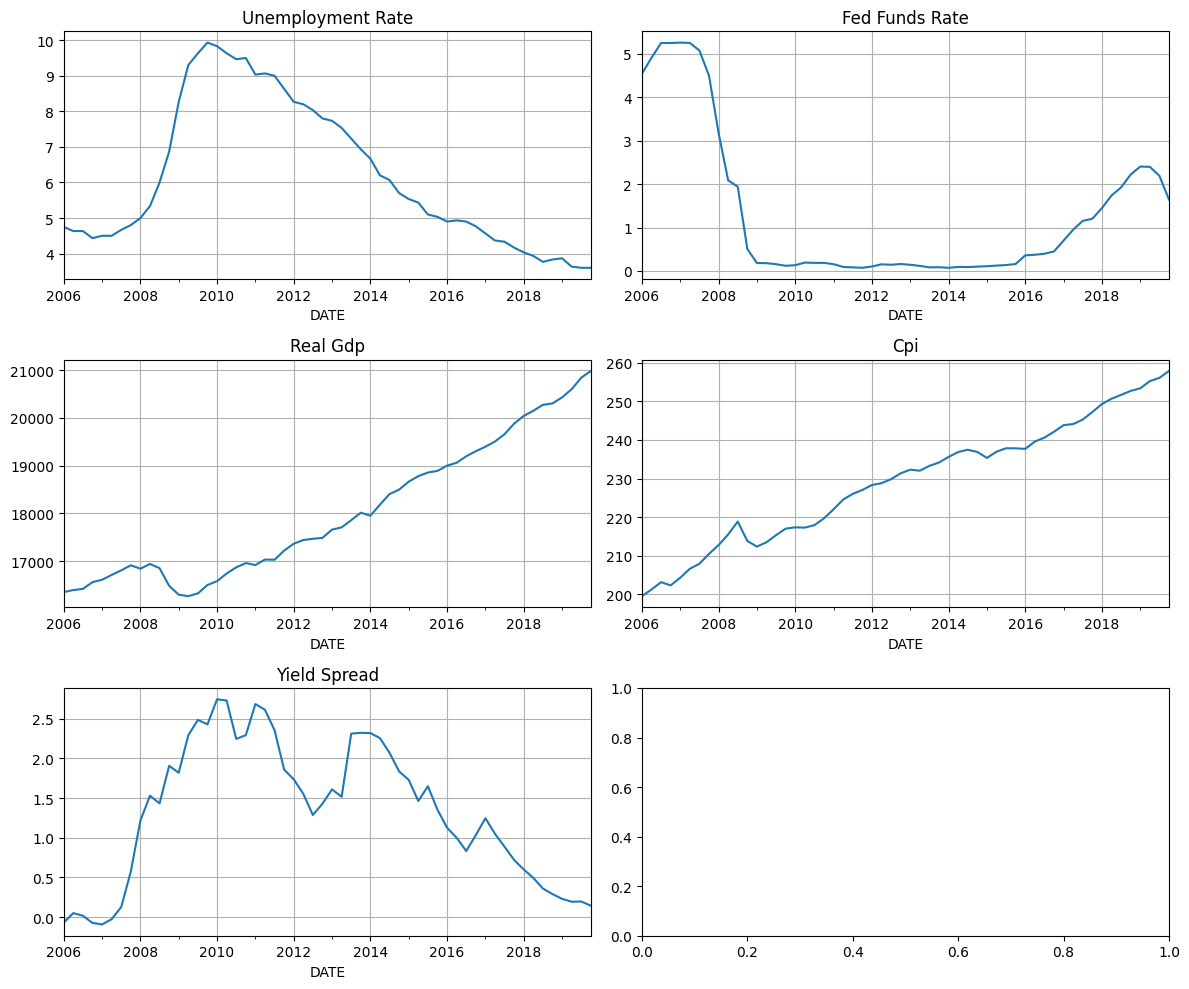

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(12,10))
axes = axes.flatten()

for ax, col in zip(axes, macro_q.columns[:-1]):
    macro_q[col].plot(ax=ax)
    ax.set_title(col.replace("_", " ").title())
    ax.grid(True)

plt.tight_layout()
plt.show()

In [14]:
baseline_macro = macro_q.drop(columns="year").mean()
baseline_macro

unemployment_rate       6.1801
fed_funds_rate          1.3017
real_gdp            18010.5681
cpi                   229.2768
yield_spread            1.3215
dtype: float64

In [15]:
scenarios = pd.DataFrame({
    "scenario": ["baseline", "adverse", "severe"],

    "unemployment_rate": [
        baseline_macro["unemployment_rate"],
        baseline_macro["unemployment_rate"] + 2.0,
        baseline_macro["unemployment_rate"] + 4.0
    ],

    "fed_funds_rate": [
        baseline_macro["fed_funds_rate"],
        baseline_macro["fed_funds_rate"] + 1.5,
        baseline_macro["fed_funds_rate"] + 3.0
    ],

    "real_gdp": [
        baseline_macro["real_gdp"],
        baseline_macro["real_gdp"] * 0.98,
        baseline_macro["real_gdp"] * 0.95
    ],

    "cpi": [
        baseline_macro["cpi"],
        baseline_macro["cpi"] * 1.05,
        baseline_macro["cpi"] * 1.10
    ],

    "yield_spread": [
        baseline_macro["yield_spread"],
        baseline_macro["yield_spread"] - 0.5,
        baseline_macro["yield_spread"] - 1.0
    ]
})

scenarios

,scenario,unemployment_rate,fed_funds_rate,real_gdp,cpi,yield_spread
0,baseline,6.1801,1.3017,18010.5681,229.2768,1.3215
1,adverse,8.1801,2.8017,17650.3567,240.7406,0.8215
2,severe,10.1801,4.3017,17110.0397,252.2044,0.3215


In [16]:
scenario_shocks = scenarios.set_index("scenario")
scenario_shocks = scenario_shocks / scenario_shocks.loc["baseline"]

scenario_shocks

,unemployment_rate,fed_funds_rate,real_gdp,cpi,yield_spread
scenario,,,,,
baseline,1.0000,1.0000,1.0000,1.0000,1.0000
adverse,1.3236,2.1523,0.9800,1.0500,0.6217
severe,1.6472,3.3046,0.9500,1.1000,0.2433


The macro data exhibits realistic cyclical behavior, including labor market stress, monetary tightening, and yield curve inversion during recessionary periods. Baseline, adverse, and severe scenarios were defined using interpretable shocks calibrated relative to long-run averages, producing consistent and defensible macro stress multipliers.

In [17]:
macro_q.to_parquet("data/processed/us_macro_quarterly.parquet")
scenarios.to_csv("data/processed/macro_scenarios_levels.csv", index=False)
scenario_shocks.to_csv("data/processed/macro_scenarios_shocks.csv")

## Summary

This notebook ingested key US macroeconomic indicators from FRED and aligned them to loan issuance
vintages at a quarterly frequency. Baseline, adverse, and severe stress scenarios were defined
using transparent and interpretable macroeconomic shocks.

These scenarios will be propagated through the credit portfolio in the next notebook to quantify
loss amplification under macroeconomic stress.